In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kyanyoga/sample-sales-data")

print("Path to dataset files:", path)

100%|██████████| 77.5k/77.5k [00:00<00:00, 768kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kyanyoga/sample-sales-data/versions/1


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns

In [20]:
file_path = "/root/.cache/kagglehub/datasets/kyanyoga/sample-sales-data/versions/1/sales_data_sample.csv"
df = pd.read_csv(file_path, encoding='latin-1')
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [31]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 877 entries, 2003-01-06 to 2005-05-31
Freq: D
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       877 non-null    float64
 1   QUANTITYORDERED   877 non-null    float64
 2   PRICEEACH         877 non-null    float64
 3   ORDERLINENUMBER   877 non-null    float64
 4   SALES             877 non-null    float64
 5   STATUS            877 non-null    object 
 6   QTR_ID            877 non-null    float64
 7   MONTH_ID          877 non-null    float64
 8   YEAR_ID           877 non-null    float64
 9   PRODUCTLINE       877 non-null    object 
 10  MSRP              877 non-null    float64
 11  PRODUCTCODE       877 non-null    object 
 12  CUSTOMERNAME      877 non-null    object 
 13  PHONE             877 non-null    object 
 14  ADDRESSLINE1      877 non-null    object 
 15  ADDRESSLINE2      873 non-null    object 
 16  CITY             

In [32]:
# Check for missing values
df.isnull().sum()

,0
ORDERNUMBER,0
QUANTITYORDERED,0
PRICEEACH,0
ORDERLINENUMBER,0
SALES,0
STATUS,0
QTR_ID,0
MONTH_ID,0
YEAR_ID,0
PRODUCTLINE,0


In [21]:
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

df = df[~df.duplicated(subset=['ORDERDATE'], keep='first')]
df.set_index('ORDERDATE', inplace=True)
df = df.asfreq('D').fillna(method='ffill')

<ipython-input-21-17eab50b5966>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.asfreq('D').fillna(method='ffill')


In [22]:
print(df.columns)

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'PRODUCTLINE',
       'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE', 'ADDRESSLINE1',
       'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE', 'COUNTRY', 'TERRITORY',
       'CONTACTLASTNAME', 'CONTACTFIRSTNAME', 'DEALSIZE'],
      dtype='object')


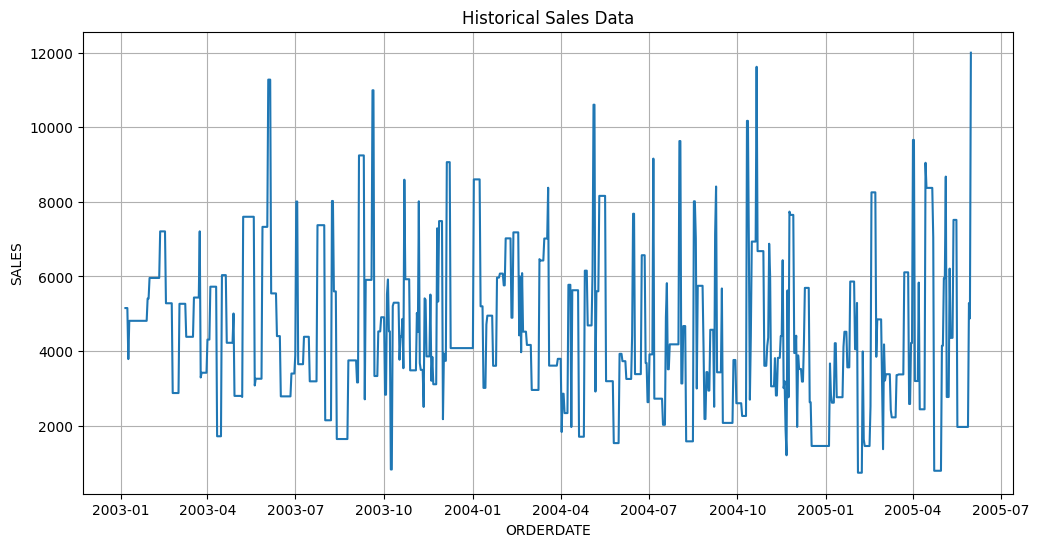

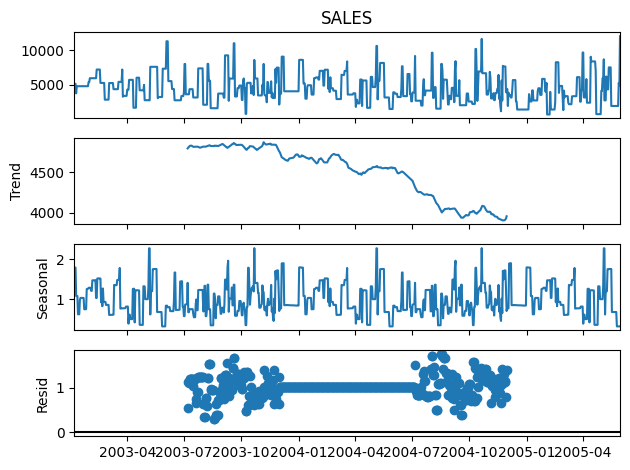

In [25]:
# Plot original data
plt.figure(figsize=(12,6))
plt.plot(df['SALES'])
plt.title('Historical Sales Data')
plt.xlabel('ORDERDATE')
plt.ylabel('SALES')
plt.grid(True)
plt.show()

# Decompose into trend, seasonality, and residuals
decomposition = seasonal_decompose(df['SALES'], model='multiplicative', period=365)
decomposition.plot()
plt.show()

In [26]:
# Split data into train/test
train = df.iloc[:-30]  # Last 30 days as test set
test = df.iloc[-30:]

# Holt-Winters Exponential Smoothing (handles trend and seasonality)
model = ExponentialSmoothing(train['SALES'],
                           trend='add',
                           seasonal='mul',
                           seasonal_periods=12).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


MAE: 2180.39, RMSE: 2693.87, MAPE: 58.08%


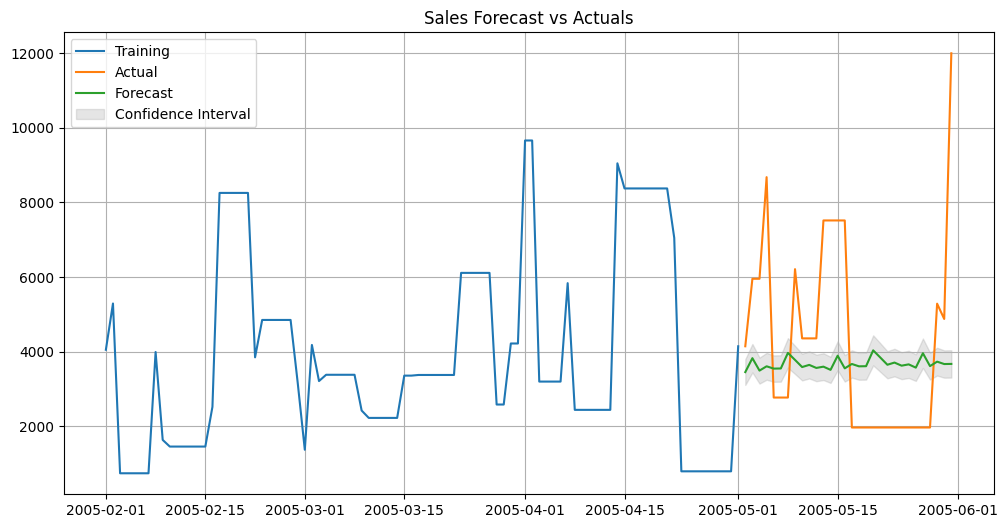

In [28]:
# Generate forecasts
forecast = model.forecast(30)  # Forecast next 30 days

# Calculate metrics
mae = mean_absolute_error(test['SALES'], forecast)
rmse = np.sqrt(mean_squared_error(test['SALES'], forecast))
mape = np.mean(np.abs((test['SALES'] - forecast) / test['SALES'])) * 100

print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%')

# Plot forecasts vs actuals
plt.figure(figsize=(12,6))
plt.plot(train.index[-90:], train['SALES'][-90:], label='Training')
plt.plot(test.index, test['SALES'], label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.fill_between(test.index,
                forecast * 0.9,
                forecast * 1.1,
                color='gray', alpha=0.2, label='Confidence Interval')
plt.title('Sales Forecast vs Actuals')
plt.legend()
plt.grid(True)
plt.show()

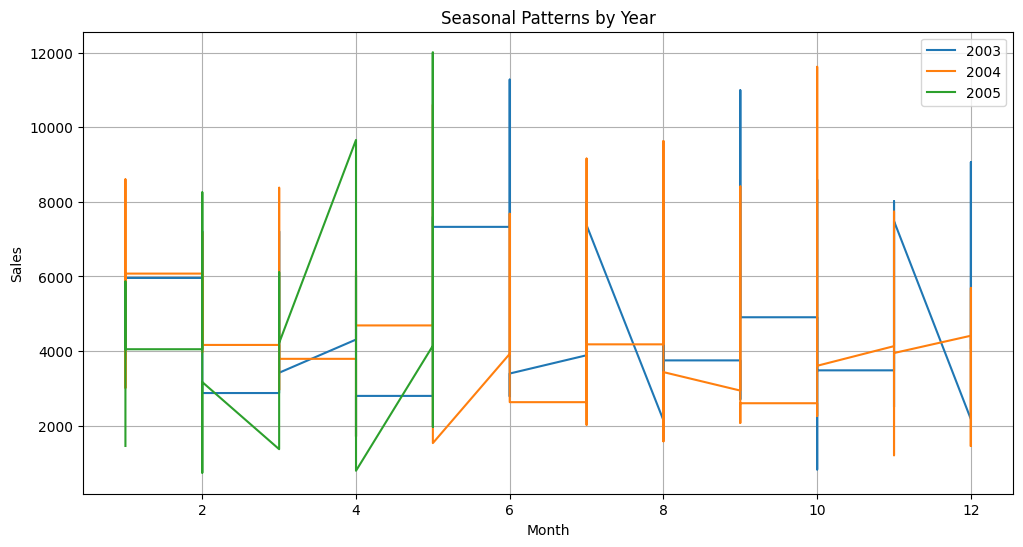

In [38]:
# Seasonal plot
years = df.index.year.unique()
plt.figure(figsize=(12,6))
for year in years:
    plt.plot(df[df.index.year == year].index.month,
             df[df.index.year == year]['SALES'],
             label=year)
plt.title('Seasonal Patterns by Year')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()



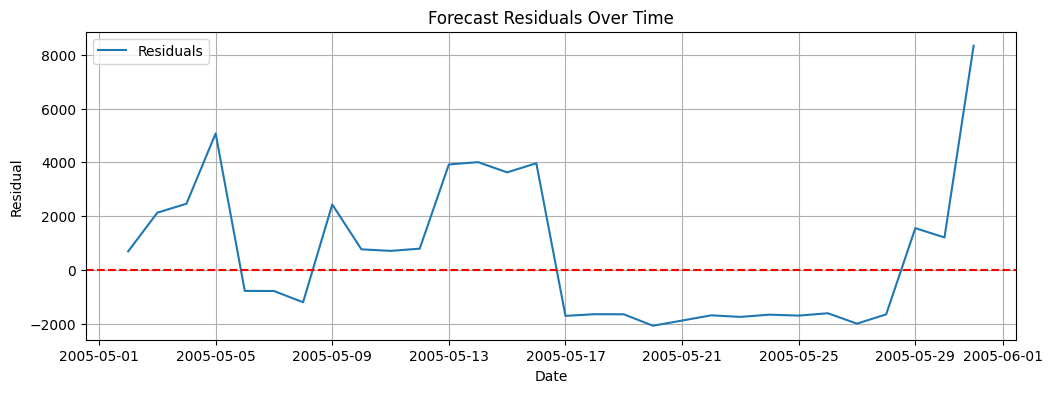

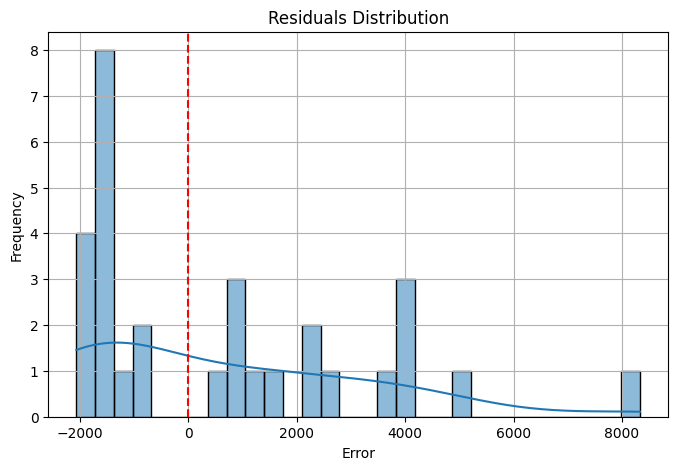

In [39]:
forecasted_values = pd.Series(forecast, index=test.index)
residuals = test['SALES'] - forecasted_values

# Residual Time Series Plot
plt.figure(figsize=(12, 4))
plt.plot(residuals, label="Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title('Forecast Residuals Over Time')
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.grid(True)
plt.show()

# Residual Distribution Plot
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.title('Residuals Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()